In [1]:
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

import sqlalchemy
import sqlalchemy_utils
import psycopg2

import pandas as pd
import numpy as np

import xml.etree.ElementTree as ET
import string
import re

import spacy
nlp = spacy.load('en_core_web_lg')
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [2]:
# Connect to db wiht sqlalchemy
dbname = 'congressional_bills'
username = 'melissaferrari'
engine = sqlalchemy.create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

postgres://melissaferrari@localhost/congressional_bills


In [3]:
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database=dbname, user=username)

### Bill topics.

In [4]:
query = """
        SELECT subjects_top_term, COUNT(*) FROM bills GROUP BY subjects_top_term;
        """

top_subjects = pd.read_sql_query(query, engine)
top_subjects = top_subjects.set_index('subjects_top_term').sort_values(by='count', ascending=False)

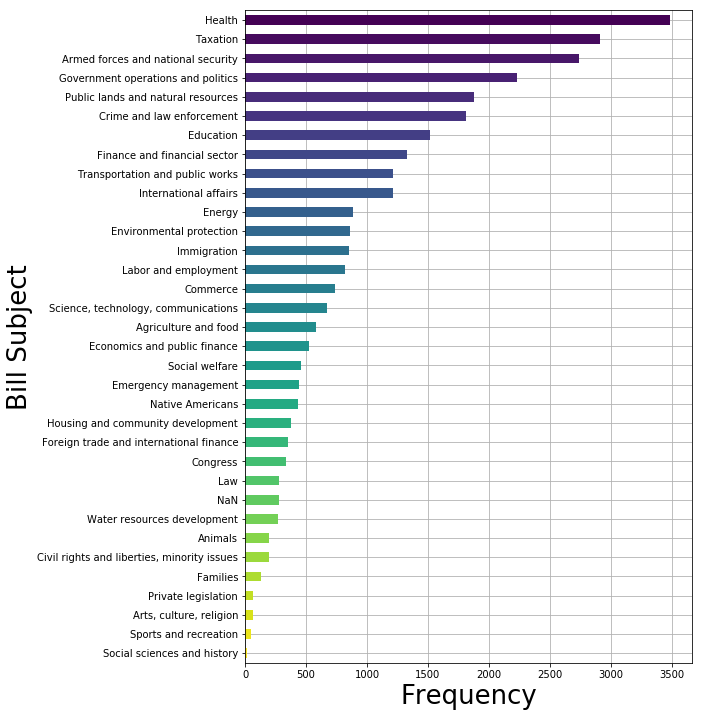

In [5]:
fig, ax = plt.subplots(figsize=(8, 12))
colors = matplotlib.cm.viridis_r(np.linspace(0, 1, len(top_subjects)))
top_subjects['count'].sort_values().plot(kind='barh', ax=ax, stacked=True, color=colors);
ax.grid(); ax.set_axisbelow(True); ax.set_ylabel('Bill Subject', size=26); ax.set_xlabel('Frequency', size=26);

In [6]:
top25 = top_subjects.nlargest(int(0.25*len(top_subjects)), 'count')
top25

,count
subjects_top_term,
Health,3490
Taxation,2915
Armed forces and national security,2741
Government operations and politics,2233
Public lands and natural resources,1876
Crime and law enforcement,1810
Education,1520
Finance and financial sector,1329


# Get tables from DB.

In [7]:
summary_table = pd.read_sql_table('summaries', con=engine, columns=None)
bills_info = pd.read_sql_table('bills', con=engine)
bills_text_table = pd.read_sql_table('bill_text', con=engine, columns=None)

In [281]:
pwd

'/Users/melissaferrari/Projects/repo/bill-summarization/notebooks'

In [ ]:
agg = pd.read_csv('../data/propublica/agg_propublica_112hr.csv')

In [280]:
summary_table.head()

,id,bill_ix,as,date,text,source
0,9677,7899,Introduced in House,2016-07-13,Marine Mammal Research and Response Act of 201...,1
1,9678,7900,Introduced in House,2015-05-21,Coastal Communities Ocean Acidification Act of...,1
2,9679,7901,Introduced in House,2015-09-10,"Police Reporting Information, Data, and Eviden...",1
3,9680,7902,Introduced in House,2015-06-12,Sanctity of Life Act of 2015\n\nDeclares that:...,1
4,9681,7903,Introduced in House,2016-02-08,Funding Unpaid National Debt with Settlements ...,1


In [279]:
bills_info.head()

,id,official_title,popular_title,url,bill_type,status_at,by_request,sponsor,updated_at,status,number,subjects_top_term,bill_id,introduced_at,congress,short_title
0,5529,To require the Securities and Exchange Commiss...,NaN,https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/...,0,2015-03-03,False,153,2017-12-11 19:28:52,4.0,1216,Finance and financial sector,hr1216-114,2015-03-03,114,Maker-Taker Conflict of Interest Reform Act of...
1,5530,To direct the Secretary of Veterans Affairs to...,NaN,https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/...,0,2016-03-16,False,12419,2017-12-11 21:02:18,4.0,4764,Armed forces and national security,hr4764-114,2016-03-16,114,Puppies Assisting Wounded Servicemembers (PAWS...
2,5531,To provide limitations on maritime liens on fi...,NaN,https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/...,0,2015-01-13,False,256,2017-12-11 19:10:21,4.0,337,Transportation and public works,hr337-114,2015-01-13,114,Maritime Lien Reform Act
3,5532,To expand the tropical disease product priorit...,NaN,https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/...,0,2016-09-14,False,279,2017-12-11 21:27:52,4.0,6033,Health,hr6033-114,2016-09-14,114,Adding Middle East Respiratory Syndrome to the...
4,5533,To establish a grant program to encourage the ...,NaN,https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/...,0,2015-05-21,False,163,2017-12-11 20:19:56,4.0,2493,Armed forces and national security,hr2493-114,2015-05-21,114,Wounded Warrior Service Dog Act of 2015


In [11]:
query = """
        SELECT 
        sm.text AS summary_text,
        sm.bill_ix, sm.as, sm.date,
        bv.code,
        bt.text AS full_text
        FROM summaries sm
        INNER JOIN bill_text bt
        ON sm.bill_ix=bt.bill_ix
        INNER JOIN bill_versions bv
        ON bv.id=bt.bill_version_id
        ;
        """
bill_inner_join = pd.read_sql_query(query, engine)

In [12]:
bill_inner_join.head()

,summary_text,bill_ix,as,date,code,full_text
0,Consumer Financial Protection Commission Act o...,27059,Introduced in House,2013-06-17,IH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
1,Children of Military Service Members Commemora...,27062,Introduced in House,2013-05-08,IH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
2,Tick-Borne Disease Research Accountability and...,27064,Passed House amended,2014-09-09,IH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
3,Tick-Borne Disease Research Accountability and...,27064,Passed House amended,2014-09-09,RH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
4,Tick-Borne Disease Research Accountability and...,27064,Passed House amended,2014-09-09,EH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."


In [13]:
subject = 'Education'
subject in list(top25.index.values)

True

In [14]:
select_cols = ['id', 'official_title', 'bill_type', 'status_at', 'sponsor', 'status', 
               'subjects_top_term', 'bill_id', 'introduced_at', 'congress', 'short_title']
ed_bills = bills_info[bills_info['subjects_top_term'] == subject][select_cols]
ed_bills = ed_bills.rename(columns={'id':'bill_ix'})
len(ed_bills)

1520

In [15]:
ed_bills_join = ed_bills.merge(bill_inner_join, on='bill_ix', how='inner')
len(ed_bills_join)

1168

In [16]:
duplicates = ed_bills_join[ed_bills_join.duplicated('bill_ix')].bill_ix.unique()

### If bill search returns multiple versions of the same bill.

In [17]:
def _return_correct_bill_version(df):
    num_rows = len(df)
    if num_rows == 0:
        raise Exception('Oh no! This bill is not in the database.')
    elif num_rows > 1:
        rank_codes = ['ENR', 'EAS', 'EAH', 'RS', 'ES', 'PCS', 'EH', 'RH', 'IS', 'IH']
        code = next(i for i in rank_codes if i in df['code'].unique())
        df = df[df['code'] == code]
    return df.iloc[0].to_dict()

In [18]:
def _check_if_unfavorable_bill(bill_dict):
    if 'to amend the' in bill_dict['official_title'].lower():
        print('this is an ammendment, proceed wiht caution')
        return True

In [19]:
ed_bills_join.bill_ix.unique()

array([ 5537,  5545,  5572, ..., 32610, 32663, 32682])

In [20]:
ix = 2
test_bill = ed_bills_join[(ed_bills_join['bill_ix']==duplicates[ix])].copy()

In [22]:
bill_ix = 5741
test_bill = ed_bills_join[(ed_bills_join['bill_ix']==bill_ix)].copy()
test_bill = _return_correct_bill_version(test_bill)

In [24]:
is_bad = _check_if_unfavorable_bill(test_bill)
is_bad

In [25]:
test_bill['bill_id']

'hr3178-114'

In [26]:
short_title = test_bill['short_title']
official_title = test_bill['official_title']
print(short_title)
print(official_title)

Strengthening Transparency in Higher Education Act
To simplify and streamline the information regarding institutions of higher education made publicly available by the Secretary of Education, and for other purposes.


## Clean text.

In [27]:
def _is_not_empty(maybe_text):
    if maybe_text and not maybe_text.isspace():
        return True

In [28]:
txt_tree = ET.ElementTree(ET.fromstring(test_bill['full_text']))
txt_root = txt_tree.getroot()
txt_descendants = list(txt_root.iter())
txt_extract = [[ix, elem.tag, elem.text] for ix, elem in enumerate(txt_root.iter()) 
               if _is_not_empty(elem.text)] #and elem.tag in ['enum', 'header', 'text']]

In [29]:
def _bill_from_xml(xml_text_string):
    txt_tree = ET.ElementTree(ET.fromstring(xml_text_string))
    txt_root = txt_tree.getroot()

    # txt_descendants = list(txt_root.iter())
    txt_extract = [[ix, elem.tag, elem.text] for ix, elem
                   in enumerate(txt_root.iter())
                   if _is_not_empty(elem.text)]
    # and elem.tag in ['enum', 'header', 'text']]

    txt_extract = _clean_extracted_list(txt_extract)
    xml_output = _full_text_tostring(txt_extract)
    full_string, enum_string, extract_sentences = xml_output
    return full_string, enum_string, extract_sentences

In [30]:
def _clean_extracted_list(txt_extract, unwanted_tags=['external-xref', 'after-quoted-block']):
    txt_extract = pd.DataFrame(txt_extract)
    txt_extract.columns = ['loc_ix', 'tag', 'text']
    
    first_ix = txt_extract.index[txt_extract['tag'] == 'short-title'].tolist()[0]
    try:
        last_ix = txt_extract.index[txt_extract['tag'] == 'attestation-date'].tolist()[0] -1
    except:
        last_ix = txt_extract.index[txt_extract['tag'] == 'text'].tolist()[-1]
    txt_extract = txt_extract.loc[first_ix:last_ix]

    return txt_extract[~txt_extract['tag'].isin(unwanted_tags)]

In [31]:
txt_extract = pd.DataFrame(txt_extract)
txt_extract.columns = ['loc_ix', 'tag', 'text']    

In [32]:
txt_extract.index[txt_extract['tag'] == 'text'].tolist()[-1]

325

In [34]:
first_ix = txt_extract.index[txt_extract['tag'] == 'short-title'].tolist()[0]

In [35]:
last_ix = txt_extract.index[txt_extract['tag'] == 'attestation-date'].tolist()[0] -1

In [36]:
txt_extract = _clean_extracted_list(txt_extract)

In [37]:
def _full_text_tostring(txt_extract, omit_tags=['header', 'short-title']):
    sentences = []
    enum_string = ""
    full_string = ""
    for ix, row in txt_extract[~txt_extract['tag'].isin(omit_tags)].iterrows():
        nextix = ix
        enum_string += row['text'] + ' '
        if row['tag'] == 'enum':
            nextix = ix + 1
        if nextix == ix:
            sentences.append(row['text'] + ' ')
            full_string += row['text'] + ' '
    return full_string, enum_string, sentences

In [38]:
full_string, enum_string, extract_sentences = _full_text_tostring(txt_extract)

In [39]:
def _tokenize_sentences(txt_string):
    doc = nlp(txt_string)
    txt_sent = [sent.string.strip() for sent in doc.sents]
    return doc, txt_sent

In [40]:
full_doc, full_sent = _tokenize_sentences(full_string)

In [41]:
def _remove_whitespace(sentence_list):
    
    white_space = list(string.whitespace)[1:]
    for ix in range(len(sentence_list)):
        for bad_string in white_space:
            if bad_string in sentence_list[ix]:
                sentence_list[ix] = sentence_list[ix].replace(bad_string, "")
    
    return sentence_list                

In [43]:
def _remove_punct_nums(sentences):
    # remove punctuations, numbers and special characters
    regex = re.compile(r"[^a-zA-Z]")
    return [regex.sub(" ", s) for s in sentences]

def _make_lowercase(sentences):
    return [s.lower() for s in sentences]

def _remove_custom(sentence_list, type='sec'):

    for ix in range(len(sentence_list)):
        s = sentence_list[ix]
        start_ix = s.find("(Sec.")
        if start_ix != -1:
            end_ix = start_ix + 8
            sentence_list[ix] = sentence_list[ix].replace(s[start_ix:end_ix], " ")
    
    return sentence_list                

In [44]:
full_sent_clean = full_sent

full_sent_clean = _remove_custom(full_sent_clean, type='sec')
full_sent_clean = _remove_whitespace(full_sent_clean)
full_sent_clean =  _remove_punct_nums(full_sent_clean)
full_sent_clean = _make_lowercase(full_sent_clean)

full_sent_clean = [s for s in full_sent_clean if _is_not_empty(s)]

In [45]:
def _extract_entities(sentences, bad_ents=['WORK_OF_ART', 'CARDINAL']):

    df_ent = pd.DataFrame()
    for ix, sentence in enumerate(sentences):
        doc = nlp(sentence)
        for ent in doc.ents:

            df_ent = df_ent.append([[ix, ent.text, ent.start_char,
                                     ent.end_char, ent.label_]], ignore_index=True)

    df_ent.columns = ['sentence', 'text', 'start_char', 'end_char', 'label']
    df_ent = df_ent[(~df_ent.label.isin(bad_ents))& (~df_ent['text'].apply(str.isspace))]

    return df_ent

In [46]:
df_ent = _extract_entities(full_sent)

In [47]:
df_ent.groupby(['label']).size()

label
DATE       24
GPE         1
LAW        15
MONEY      10
NORP        1
ORDINAL     8
ORG        45
PERCENT     3
PERSON      5
TIME        2
dtype: int64

### IMPORTANT NOTE WRT ORDERED LISTS:
Here I chose to go with the spacy tokenized version of `full_string` rather than `extracted_sentences` because they put all bullet points in one block.

#### Get word embeddings.

In [74]:
def _extract_embeddings(path_to_embedding = '../nlp_models/glove.6B/glove.6B.300d.txt'):
    f = open(path_to_embedding, encoding='utf-8')
    word_embeddings = {}
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs
    f.close()
    embedding_size = list(coefs.shape)[0]
    return word_embeddings, embedding_size 

In [75]:
word_embeddings, embedding_size = _extract_embeddings()

In [76]:
def _calc_embedding(sen, word_embeddings, embedding_size):
    if embedding_size == None:
        embedding_size = random.choice(list(word_embeddings.values())).shape
    if len(sen) != 0:
        vector = sum([word_embeddings.get(w, np.zeros(embedding_size)) for w in sen.split()])/(len(sen.split())+0.001)
    else:
        vector = np.zeros(embedding_size)
    return vector

In [77]:
len(full_sent_clean)

66

In [78]:
s = full_sent_clean[0]
s

'section     of the higher education act of        in subsection  a   in paragraph      by striking  first time  in paragraph     in the matter preceding subparagraph  a   by striking  first time  in paragraph      by striking  first time  in subsection  b   in paragraph      by striking  first time  in paragraph      by striking  first time  by striking subsections  c  through  g    j   and  l   by redesignating subsections  h    i   and  k  as subsections  c    d   and  e   respectively  and by striking subsection  d   as so redesignated  and inserting the following new subsection  the secretary shall develop and make publicly available a website to be known as the  college dashboard website'

In [80]:
full_vec = [_calc_embedding(s, word_embeddings, embedding_size) for s in full_sent_clean]

### Prepare summary.

In [81]:
summ_string = test_bill['summary_text']
summ_doc, summ_sent = _tokenize_sentences(summ_string)

In [82]:
print(summ_string)

Strengthening Transparency in Higher Education Act

(Sec. 2) This bill amends title I (General Provisions) of the Higher Education Act of 1965 to modify consumer information disclosure requirements related to college costs and student characteristics.

Specifically, it eliminates the existing restriction that limits calculations of cost of attendance, net price, and tuition and fees to first time students only.

Additionally, it eliminates provisions that require the Department of Education (ED) to make publicly available the following: (1) college affordability and transparency lists, (2) annual summaries of institutional reports, (3) state higher education spending charts; and (4) a multi-year tuition and fees calculator.

(Sec. 3) The bill directs ED to develop, annually update, and make publicly available a College Dashboard website to replace the College Navigator website.

It revises the consumer information ED must make publicly available regarding an institution that participat

In [83]:
summ_sent_clean = summ_sent

summ_sent_clean = _remove_custom(summ_sent_clean, type='sec')
summ_sent_clean = _remove_whitespace(summ_sent)
summ_sent_clean =  _remove_punct_nums(summ_sent_clean)
summ_sent_clean = _make_lowercase(summ_sent_clean)

summ_sent_clean = [s for s in summ_sent_clean if _is_not_empty(s)]

In [84]:
summ_vec = [_calc_embedding(s, word_embeddings, embedding_size) for s in summ_sent_clean]

### Match summary.

In [90]:
def _create_sim_mat(sent_vecs_1, sent_vecs_2,
                    embedding_size):
    sim_mat = np.zeros([len(sent_vecs_1), len(sent_vecs_2)])
    vlen = embedding_size
    for i in range(len(sent_vecs_1)):
        for j in range(len(sent_vecs_2)):
            sim_mat[i][j] = metrics.pairwise.cosine_similarity(sent_vecs_1[i].reshape(1, vlen),
                                                               sent_vecs_2[j].reshape(1,vlen))[0, 0]
    return sim_mat

In [91]:
from sklearn import metrics

In [711]:
sim_mat = _create_sim_mat(full_vec, summ_vec, 300)

In [712]:
ix_sort = (-sim_mat).argsort(axis=0)[:1][0]
ix_match = np.sort(ix_sort)
ix_match = np.unique(ix_match)

In [713]:
ix_sort = (-sim_mat).argsort(axis=0)

In [716]:
len(ix_sort[:1][0])

10

In [715]:
len(np.unique(ix_sort[:1][0]))

7

In [705]:
ix_match

array([25, 47, 51, 52, 55, 63, 64])

**first pass:** Just choose not duplicates.

In [96]:
closest_match = [full_sent[i] for i in ix_match]

In [97]:
closest_match

['The Secretary shall publish on Internet webpages that are linked to through the College Dashboard website for the most recent academic year for which satisfactory data is available the following information with respect to each institution of higher education that participates in a program under title IV:',
 'In developing and maintaining the College Dashboard website, the Secretary, in consultation with appropriate departments and agencies of the Federal Government, shall conduct consumer testing with appropriate persons, including current and prospective college students, family members of such students, institutions of higher education, and experts, to ensure that the College Dashboard website is usable and easily understandable and provides useful and relevant information to students and families.',
 'Any reference in this Act to the College Navigator website shall be considered a reference to the College Dashboard website.',
 'The Higher Education Act of 1965 ( in section 131(h)

In [378]:
len(full_vec)

66

In [379]:
len(summ_vec)

10

In [381]:
full_vec[0].shape

(300,)

In [386]:
ix_match

array([25, 47, 51, 52, 55, 63, 64])

In [385]:
summ_data.head()

,embed_000,embed_001,embed_002,embed_003,embed_004,embed_005,embed_006,embed_007,embed_008,embed_009,...,embed_290,embed_291,embed_292,embed_293,embed_294,embed_295,embed_296,embed_297,embed_298,embed_299
0,-0.233038,-0.074175,-0.218179,0.010292,0.033941,0.078535,0.101503,0.158522,-0.015748,-1.917280,...,-0.215669,-0.041234,-0.332170,-0.081211,0.273404,0.594429,-0.293826,-0.321401,0.001302,-0.129171
1,-0.104228,-0.011433,-0.082461,-0.122899,-0.040382,0.028815,0.056263,0.107998,0.025880,-1.566172,...,-0.004620,-0.179744,0.032588,-0.104200,0.250103,0.161437,-0.154340,-0.188333,-0.059551,-0.038539
2,-0.114165,0.125716,0.022830,0.015403,-0.066008,0.048693,0.112928,0.020572,0.025155,-1.468614,...,-0.077938,-0.131802,-0.024619,0.071443,0.159662,0.035058,-0.039015,-0.150076,0.050173,-0.018329
3,-0.113451,0.012993,0.040164,-0.053407,-0.079402,0.102866,0.120478,0.052501,-0.071775,-1.343217,...,-0.083765,-0.115471,-0.128446,0.019612,0.122135,0.199958,-0.050150,-0.172595,-0.063902,-0.021127
4,-0.172515,0.013520,-0.030504,-0.116850,-0.157971,0.095571,-0.022992,-0.022517,0.025425,-1.156716,...,-0.070120,-0.156110,-0.159601,0.062036,0.046292,0.071550,-0.061045,-0.120347,-0.148255,0.045631


In [398]:
embedding_size = 100

In [388]:
data = pd.DataFrame(full_vec, columns=['embed_{:03}'.format(i)
                            for i in range(embedding_size)])
data['in_summary'] = 0
data.loc[ix_match, 'in_summary'] = 1
summ_data = pd.DataFrame(summ_vec, columns=['embed_{:03}'.format(i)
                            for i in range(embedding_size)])
summ_data['in_summary'] = 2
all_data = pd.concat([data, summ_data])
all_data['in_summary'].unique()

In [399]:
data = pd.concat([data, summ_data])

In [391]:
summ_data.shape

(10, 301)

In [400]:
data.shape

(76, 301)

array([0, 1, 2])

### Training dataset.

In [149]:
data = pd.DataFrame(full_vec, columns = ['embed_{:03}'.format(i) for i in range(300)])
data['in_summary'] = 0
data.loc[ix_match, 'in_summary'] = 1
assert(len(data[data['in_summary'] != 1]) + len(data[data['in_summary'] == 1]) == len(data))

### Test.train.split.

In [587]:
import os
from sklearn.linear_model import LogisticRegression

In [588]:
PATH_TO_TRAINING = '../data/training_data/'
TRAINING_FILES = os.listdir(PATH_TO_TRAINING)


In [589]:
TRAINING_FILES

['trainingdata_v1_leGLOVEemb100_Education.csv',
 'trainingdata_v1_emb100_Education.csv',
 'trainingdata_v1_GLOVEemb100_Education.csv',
 'allembeddings_v1_GLOVEemb100_Education.csv',
 'allembeddings_v1_leGLOVEemb100_Education.csv']

In [590]:
file_name = TRAINING_FILES[2]
file_name

'trainingdata_v1_GLOVEemb100_Education.csv'

In [591]:
training_data = pd.read_csv(PATH_TO_TRAINING + file_name)
del training_data['Unnamed: 0']

In [507]:
file_name = TRAINING_FILES[2]
file_name

'allembeddings_v1_GLOVEemb100_Education.csv'

In [508]:
all_embeddings = pd.read_csv(PATH_TO_TRAINING + file_name)
del all_embeddings['Unnamed: 0']

In [592]:
training_data.shape

(33333, 101)

In [593]:
all_embeddings.shape

(38651, 101)

In [511]:
all_embeddings.groupby('in_summary').size()

in_summary
0    29426
1     3907
2     5318
dtype: int64

In [594]:
import random

In [595]:
train_ind = np.random.choice(len(training_data), int(len(training_data)*.8))
test_ind = np.setdiff1d(train_ind, np.arange(len(training_data)))

In [457]:
train = training_data.loc[train_ind]
train_X = train.drop(columns=['in_summary'])
train_Y = train[['in_summary']]

test = training_data.loc[test_ind]
test_X = test.drop(columns=['in_summary'])
test_Y = test[['in_summary']]

In [849]:
train = data[0:40]
train_X = train.drop(columns=['in_summary'])
train_Y = train[['in_summary']]

test = data[40:]
test_X = test.drop(columns=['in_summary'])
test_Y = test[['in_summary']]

In [458]:
model = LogisticRegression(C=1e5, solver='lbfgs')#, max_iter=1000)
mdl = model.fit(train_X, train_Y.values.ravel())

/Users/melissaferrari/anaconda3/envs/congress_py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [679]:
target_names

['not_summary', 'in_summary', 'is_summary']

In [459]:
mdl.predict(train_X);

In [151]:
data.shape

(66, 301)

# [SOURCE](https://nlpforhackers.io/classification-performance-metrics/)
### [Other NLP libraries](https://nlpforhackers.io/libraries/)

In [282]:
import sklearn

In [596]:
X = training_data.drop(columns=['in_summary'])
y = training_data[['in_summary']]

In [604]:
from sklearn.linear_model import SGDClassifier
X_train, X_test, y_train, y_test = split_data(X, y)
trial6 = sklearn.pipeline.Pipeline([('SGD', sklearn.linear_model.SGDClassifier()), ])
mdl = basic_classifier_train(trial6, X_train, X_test, y_train, y_test)
mdl

Accuracy: 0.8824094072474202 


/Users/melissaferrari/anaconda3/envs/congress_py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Pipeline(memory=None,
     steps=[('SGD', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [607]:
trial2 = sklearn.pipeline.Pipeline([('classifier', sklearn.naive_bayes.GaussianNB()), ])
 
mdl = basic_classifier_train(trial2, X_train, X_test, y_train, y_test)
mdl

Accuracy: 0.43040556755459564 


Pipeline(memory=None,
     steps=[('classifier', GaussianNB(priors=None, var_smoothing=1e-09))])

In [ ]:
from sklearn.linear_model import SGDClassifier
X_train, X_test, y_train, y_test = split_data(X, y)
trial6 = sklearn.pipeline.Pipeline([('SGD', sklearn.linear_model.SGDClassifier()), ])
mdl = basic_classifier_train(trial6, X_train, X_test, y_train, y_test)
mdl

In [610]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [701]:
classifiers = [RandomForestClassifier(n_estimators=1000, random_state=0), 
               SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=100, tol=1e-3), 
              LogisticRegression(C=1e5, solver='lbfgs', max_iter=100000)]

In [702]:
classifier = classifiers[2]
classifier

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [703]:
#classifier = classifiers[0]
mdl = basic_classifier_train(classifier, X_train, X_test, y_train, y_test)

Accuracy: 0.8820494360451164 


In [704]:
report = calculate_metrics(mdl, X_test, y_test, as_csv=True, save=False)
report

,f1-score,precision,recall,support
0,0.937329,0.883321,0.998370,7363.0
1,0.000000,0.000000,0.000000,971.0
micro avg,0.882049,0.882049,0.882049,8334.0
macro avg,0.468664,0.441661,0.499185,8334.0
weighted avg,0.828120,0.780405,0.882049,8334.0


In [632]:
classifier = classifiers[0]
mdl = basic_classifier_train(classifier, X_train, X_test, y_train, y_test)

Accuracy: 0.9204463642908567 


In [645]:
report = calculate_metrics(mdl, X_test, y_test, as_csv=True, save=False)
report

,f1-score,precision,recall,support
0,0.956476,0.925667,0.989406,7363.0
1,0.537979,0.831897,0.397528,971.0
micro avg,0.920446,0.920446,0.920446,8334.0
macro avg,0.747228,0.878782,0.693467,8334.0
weighted avg,0.907717,0.914742,0.920446,8334.0


In [654]:
y_pred = mdl.predict(X_test)

In [657]:
X_test.shape

(8334, 100)

In [656]:
len(y_pred)

8334

In [636]:
model_save_path = '../models/'

In [639]:
file_name = 'RandomForestClassifier_on_trainingdata_v1_GLOVEemb100_Education_nestimators1000_random_state0.pkl'

In [641]:
with open(model_save_path+file_name, 'wb') as picklefile:
    pickle.dump(mdl, picklefile)

In [643]:
mdl_2 = load_model(model_save_path+file_name)

In [650]:
report_name = (model_save_path + file_name).replace('.pkl', '_classification_report.csv')

In [652]:
report.to_csv(report_name)

In [653]:
from sklearn.metrics import confusion_matrix

In [667]:
y_test.values.ravel().shape

(8334,)

In [668]:
y_pred.shape

(8334,)

In [670]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

In [671]:
cnf_matrix

array([[7285,   78],
       [ 585,  386]])

In [675]:
class_names = target_names[:2]
class_names

['not_summary', 'in_summary']

Confusion matrix, without normalization
[[7285   78]
 [ 585  386]]
Normalized confusion matrix
[[0.99 0.01]
 [0.6  0.4 ]]


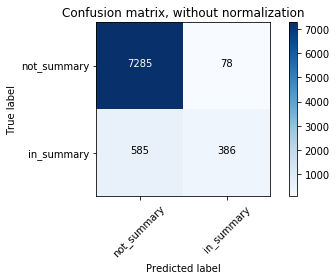

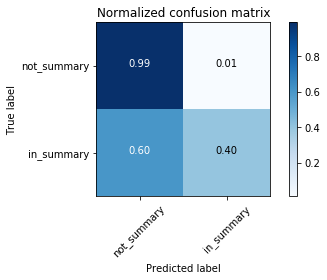

In [678]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [677]:
import itertoolsa


In [658]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [648]:
def save_model(model, model_save_path, save_report=True):
    with open(model_save_path, 'wb') as picklefile:
        pickle.dump(model, picklefile)
    if save_report:
        report_name = model_save_path.replace('.pkl',
                                              '_classification_report.csv')
        save_report.to_csv(report_name)


In [642]:
def load_model(model_save_path):
    with open(model_save_path, 'rb') as training_model:
        model = pickle.load(training_model)
    return model

In [630]:
def calculate_metrics(model, X_test, y_test,
                      as_csv=True, save=False,
                      report_name="report.csv"):
    report = classification_report(y_test, model.predict(X_test),
                                   output_dict=True)
    if as_csv:
        report = pd.DataFrame(report).transpose()
    return report

In [681]:
classification_report?

Signature:
classification_report(
    ['y_true', 'y_pred', 'labels=None', 'target_names=None', 'sample_weight=None', 'digits=2', 'output_dict=False'],
)
Docstring:
Build a text report showing the main classification metrics

Read more in the :ref:`User Guide <classification_report>`.

Parameters
----------
y_true : 1d array-like, or label indicator array / sparse matrix
    Ground truth (correct) target values.

y_pred : 1d array-like, or label indicator array / sparse matrix
    Estimated targets as returned by a classifier.

labels : array, shape = [n_labels]
    Optional list of label indices to include in the report.

target_names : list of strings
    Optional display names matching the labels (same order).

sample_weight : array-like of shape = [n_samples], optional
    Sample weights.

digits : int
    Number of digits for formatting output floating point values.
    When ``output_dict`` is ``True``, this will be ignored and the
    returned values will not be rounded.

output_d

In [598]:
def split_data(X, y):
    (X_train,
     X_test,
     y_train,
     y_test) = sklearn.model_selection.train_test_split(X, y, test_size=0.25, random_state=33)
    return X_train, X_test, y_train, y_test

In [599]:

def basic_classifier_train(classifier,
                           X_train, X_test, y_train, y_test):

    classifier.fit(X_train, y_train.values.ravel())
    print("Accuracy: {} ".format(classifier.score(X_test, y_test.values.ravel())))
    return classifier

In [600]:
trial1 = sklearn.pipeline.Pipeline([('vectorizer', sklearn.feature_extraction.text.TfidfVectorizer()),
                                    ('classifier', sklearn.naive_bayes.MultinomialNB()), ])

In [277]:
X_words = np.array(full_sent)
X = data.drop(columns=['in_summary'])
y = data[['in_summary']]

In [220]:
X_train, X_test, y_train, y_test = split_data(X_words, y)
mdl = basic_classifier_train(trial1, X_train, X_test, y_train, y_test)
mdl

Accuracy: 0.9411764705882353 


Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=...      vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [266]:
from sklearn.feature_extraction.text import HashingVectorizer
vector = vectorizer.transform(X_words)
# list of text documents
text = ["The quick brown fox jumped over the lazy dog."]
# create the transform
vectorizer = HashingVectorizer(n_features=20)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

(1, 20)
[[ 0.          0.          0.          0.          0.          0.33333333
   0.         -0.33333333  0.33333333  0.          0.          0.33333333
   0.          0.          0.         -0.33333333  0.          0.
  -0.66666667  0.        ]]


In [267]:
vectorizer = HashingVectorizer(n_features=20)
vector = vectorizer.transform(X_words)
vector.toarray()

## custom hashing 
[CUSTOM HASHING](https://towardsdatascience.com/hacking-scikit-learns-vectorizers-9ef26a7170af)

In [221]:
sklearn.metrics.accuracy_score(y_test, mdl.predict(X_test))   

0.9411764705882353

In [224]:
print(sklearn.metrics.precision_score(y_test, mdl.predict(X_test), pos_label=0) )
print(sklearn.metrics.precision_score(y_test, mdl.predict(X_test), pos_label=1) )

0.9411764705882353
0.0


In [225]:
print(sklearn.metrics.recall_score(y_test, mdl.predict(X_test), pos_label=0))
print(sklearn.metrics.recall_score(y_test, mdl.predict(X_test), pos_label=1))

1.0
0.0


In [242]:
print(sklearn.metrics.f1_score(y_test, mdl.predict(X_test), pos_label=1))

0.0


/Users/melissaferrari/anaconda3/envs/congress_py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [227]:
print(sklearn.metrics.f1_score(y_test, mdl.predict(X_test), pos_label=0))
print(sklearn.metrics.f1_score(y_test, mdl.predict(X_test), pos_label=1))

0.9696969696969697
0.0


In [250]:
print(sklearn.__version__)

0.20.2


In [252]:
classification_report = sklearn.metrics.classification_report(y_test, mdl.predict(X_test), output_dict=True)
print(sklearn.metrics.classification_report(y_test, mdl.predict(X_test), output_dict=False))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       0.00      0.00      0.00         1

   micro avg       0.94      0.94      0.94        17
   macro avg       0.47      0.50      0.48        17
weighted avg       0.89      0.94      0.91        17



In [265]:
classification_report = pd.DataFrame(classification_report).transpose()

,f1-score,precision,recall,support
0,0.969697,0.941176,1.000000,16.0
1,0.000000,0.000000,0.000000,1.0
micro avg,0.941176,0.941176,0.941176,17.0
macro avg,0.484848,0.470588,0.500000,17.0
weighted avg,0.912656,0.885813,0.941176,17.0


In [232]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, mdl.predict(X_test))
confusion_matrix_normed = confusion_matrix.astype(float) / confusion_matrix.sum(axis=1)
print(confusion_matrix_normed)

[[1.     0.    ]
 [0.0625 0.    ]]


In [208]:
from nltk.corpus import stopwords
 
trial2 = sklearn.pipeline.Pipeline([('vectorizer', sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stopwords.words('english'))),
                                    ('classifier', sklearn.naive_bayes.MultinomialNB()), ])
 
basic_classifier_train(trial2, X_train, X_test, y_train, y_test)

Accuracy: 0.9411764705882353 


Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=...      vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [209]:
trial3 = sklearn.pipeline.Pipeline([('vectorizer', sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stopwords.words('english'))),
                                    ('classifier', sklearn.naive_bayes.MultinomialNB(alpha=0.05)), ])

basic_classifier_train(trial3, X_train, X_test, y_train, y_test)

Accuracy: 0.7647058823529411 


Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=...     vocabulary=None)), ('classifier', MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True))])

In [210]:
trial4 = sklearn.pipeline.Pipeline([('vectorizer', sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stopwords.words('english'), min_df=5)),
                                    ('classifier', MultinomialNB(alpha=0.05)),])
 
basic_classifier_train(trial4, X_train, X_test, y_train, y_test)

Accuracy: 0.8823529411764706 


Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=...     vocabulary=None)), ('classifier', MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True))])

In [213]:
import string
from nltk.stem import PorterStemmer
from nltk import word_tokenize
 
def stemming_tokenizer(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in word_tokenize(text)]
 
trial5 = sklearn.pipeline.Pipeline([('vectorizer', sklearn.feature_extraction.text.TfidfVectorizer(tokenizer=stemming_tokenizer,
                                                                                                   stop_words=stopwords.words('english') + list(string.punctuation))),
                                    ('classifier', sklearn.naive_bayes.MultinomialNB(alpha=0.05)),])
 
basic_classifier_train(trial5, X_train, X_test, y_train, y_test)

Accuracy: 0.7647058823529411 


/Users/melissaferrari/anaconda3/envs/congress_py36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=...rue, vocabulary=None)), ('classifier', MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True))])

In [234]:
tfidfconverter = sklearn.feature_extraction.text.TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))  

In [238]:
tfidf = tfidfconverter.fit_transform(full_sent).toarray()  

In [241]:
tfidf.shape

(66, 44)

numpy.ndarray

### Show summary results.

In [712]:
inds = test_Y[test_Y['in_summary'] == 1].index.values

In [713]:
[full_sent[i] for i in inds]

['Not later than 1 year after the date of enactment of this Act, the Secretary of Education, acting through the Director of the Institute of Education Sciences, shall begin conducting a rigorous, longitudinal study of the impact and effectiveness of the student loan',
 'Of the amount authorized to be appropriated for maintaining the Department of Education’s Financial Awareness Counseling Tool, $2,000,000 shall be available to carry out this Act and the amendments made by this Act.']

# Data Cleaning

In [ ]:
documents = []

for sen in range(0, len(X)):  
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    # Converting to Lowercase
    document = document.lower()

    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)

    documents.append(document)

# t-SNE and PCA

In [296]:
import pickle

In [311]:
def _extract_embeddings(path_to_embedding = '../nlp_models/glove.6B/glove.6B.100d.txt'):
    f = open(path_to_embedding, encoding='utf-8')
    word_embeddings = {}
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs
    f.close()
    embedding_size = list(coefs.shape)[0]
    return word_embeddings, embedding_size 

In [312]:
word_embeddings, embedding_size = _extract_embeddings()

In [561]:
def get_leglove():
    with open(PATH_TO_NLP_MODELS + 'LeGlove.model', 'rb') as f:
        embeddings = pickle.load(f, encoding='latin-1')
    return embeddings

In [315]:
type(word_embeddings)

dict

In [328]:
glove_words = list(word_embeddings.keys())
num_glove = len(glove_words)
num_glove

400000

In [329]:
leglove_words = list(embeddings['dictionary'].keys())
num_leglove = len(leglove_words)
num_leglove

417228

In [333]:
common_elements = list(set(leglove_words).intersection(set(glove_words)))
num_intersection  = len(common_elements)
num_intersection

112432

In [334]:
num_leglove - num_intersection

304796

In [335]:
common_elements[0]

'television'

In [336]:
element = common_elements[0]

In [339]:
word_embeddings[element].shape

(100,)

In [495]:
word_ix = embeddings['dictionary'][element]
vec = embeddings['word_vectors'][word_ix]

In [499]:
w = element
w

'supreme'

In [502]:
len(embeddings['word_vectors'][embeddings['dictionary']['the']])

100

In [500]:
embeddings['word_vectors'][embeddings['dictionary'][w]]

array([-0.33256069,  0.45081048,  0.18159551,  0.35142425,  0.42925997,
        0.24251943, -0.31222567,  0.16857818,  0.10487417,  0.17459872,
        0.05626841,  0.39545409, -0.64074039,  0.31134962,  0.32126721,
       -0.66217991,  0.3225435 ,  0.54136892,  0.12075015,  0.1088831 ,
       -0.4490691 ,  0.10253409,  0.03713937,  0.42899719,  0.08103938,
       -0.111377  ,  0.03803146,  0.01319338,  0.73863588,  0.07768208,
       -0.26196016, -0.11495742,  0.08491413,  0.49704161, -0.24761482,
        0.25578941,  0.24237588, -0.01352353, -0.25006826,  0.11161443,
       -0.47440367,  0.18288653, -0.20198073, -0.22985938, -0.23405689,
        0.1485791 , -0.10622614, -0.22701101, -0.70963584,  0.19918758,
       -0.129935  , -0.44608956, -0.28940541, -0.36727911,  0.05024305,
       -0.00337242,  0.12913072, -0.15515194, -0.12194268, -0.20263742,
       -0.18151455,  0.38841657,  0.77165956,  0.11477052,  0.20389284,
        0.69167191,  0.13279086,  0.17162554, -0.18641762,  0.30

In [586]:
PATH_TO_TRAINING = '../data/training_data/'
PATH_TO_MODELS = '../../models/'
PATH_TO_NLP_MODELS = '../nlp_models/'

In [585]:
embeddings = get_leglove()
embeddings.keys()

dict_keys(['no_components', 'word_biases', 'max_loss', 'word_vectors', 'dictionary', 'learning_rate', 'max_count', 'inverse_dictionary', 'random_state', 'vectors_sum_gradients', 'alpha', 'biases_sum_gradients'])

In [512]:
X = all_embeddings.drop(columns=['in_summary'])
y = all_embeddings[['in_summary']]

In [513]:
from sklearn.manifold import TSNE

In [514]:
tsne = TSNE(n_components=2, random_state=0)

In [527]:
X_ind_rand = np.random.choice(len(X), int(len(X)*.2))

In [535]:
y_rand = y.loc[X_ind_rand]

In [536]:
y_rand.groupby('in_summary').size()

in_summary
0    5908
1     770
2    1052
dtype: int64

In [530]:
X_2d = tsne.fit_transform(X.loc[X_ind_rand])

In [531]:
X_2d.shape

(7730, 2)

In [532]:
target_ids = range(len(y.in_summary.unique()))
target_ids

range(0, 3)

In [533]:
target_names = ['not_summary', 'in_summary', 'is_summary']

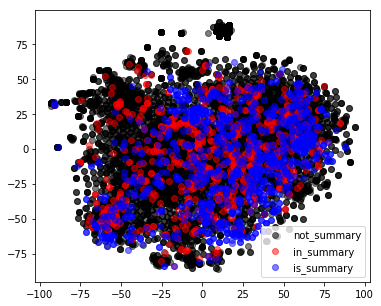

In [538]:
plt.figure(figsize=(6, 5))
colors =  'k', 'r', 'b'
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(X_2d[(y_rand==i).values.ravel(), 0],
                X_2d[(y_rand==i).values.ravel(), 1], c=c, label=label, alpha=0.5)
plt.legend()
plt.show()

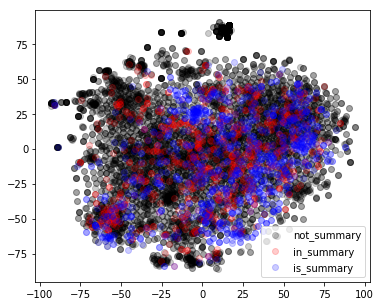

In [540]:
fig, ax = plt.subplots(figsize=(6, 5))
i=0
c='k'
alpha=0.2
label= target_names[0]
ax.scatter(X_2d[(y_rand==i).values.ravel(), 0],
                X_2d[(y_rand==i).values.ravel(), 1], c=c, label=label, alpha=alpha)

i=1
c='r'
alpha=0.2
label= target_names[1]
ax.scatter(X_2d[(y_rand==i).values.ravel(), 0],
                X_2d[(y_rand==i).values.ravel(), 1], c=c, label=label, alpha=alpha)

i=2
c='b'
alpha=0.2
label= target_names[2]
ax.scatter(X_2d[(y_rand==i).values.ravel(), 0],
                X_2d[(y_rand==i).values.ravel(), 1], c=c, label=label, alpha=alpha)


ax.legend()

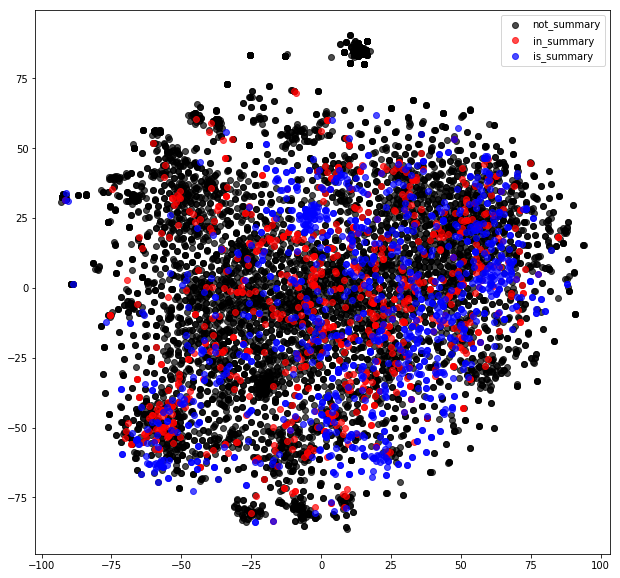

In [547]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_aspect('equal')
colors =  'k', 'r', 'b'
for i, c, label in zip(target_ids, colors, target_names):
    ax.scatter(X_2d[(y_rand==i).values.ravel(), 0],
                X_2d[(y_rand==i).values.ravel(), 1], c=c, label=label, alpha=.7)
ax.legend();

In [682]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


# [FINE TUNE CLASSIFICATION](https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65)


In [686]:
def grid_search_wrapper(clf, refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [687]:
mdl

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [689]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [690]:
grid_search_clf = grid_search_wrapper(mdl, refit_score='precision_score')

KeyboardInterrupt: 